In [12]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
with open('chat.txt', "r+") as file:
    chat = file.readlines()

In [14]:
chat = "\n".join(chat)

In [15]:
chars = sorted(list(set(chat))) + ['<s>']
vocab_size = len(chars)
tokeniser = {c:i  for i, c in enumerate(chars)}
detokeniser = {i:c  for i, c in enumerate(chars)}

In [16]:
sentence_enc = [tokeniser[c] for c in chat[:100]]
sentence_dec = [detokeniser[t] for t in sentence_enc]
sentence_enc, "".join(sentence_dec)

([61,
  19,
  23,
  17,
  18,
  26,
  17,
  20,
  18,
  20,
  23,
  14,
  2,
  19,
  18,
  28,
  22,
  23,
  28,
  22,
  21,
  63,
  2,
  45,
  74,
  79,
  72,
  84,
  2,
  37,
  83,
  80,
  84,
  84,
  2,
  42,
  66,
  68,
  76,
  2,
  46,
  66,
  67,
  28,
  2,
  133,
  47,
  70,
  84,
  84,
  66,
  72,
  70,
  84,
  2,
  66,
  79,
  69,
  2,
  68,
  66,
  77,
  77,
  84,
  2,
  66,
  83,
  70,
  2,
  70,
  79,
  69,
  15,
  85,
  80,
  15,
  70,
  79,
  69,
  2,
  70,
  79,
  68,
  83,
  90,
  81,
  85,
  70,
  69,
  16,
  2,
  49,
  79,
  77,
  90,
  2,
  81,
  70,
  80,
  81],
 '[15/08/2025, 10:45:43] Kings Cross Hack Lab: \u200eMessages and calls are end-to-end encrypted. Only peop')

In [351]:
# generating the dataset
CONTEXT_LENGTH = 128
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context])
    if i < len(chat) - 1:
        Y.append(tokeniser[chat[i + 1]])
    else:
        Y.append(tokeniser[" "])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [86]:
emb = torch.randn(vocab_size, 2)
emb.shape

torch.Size([343, 2])

In [91]:
emb_X = emb[X]

In [92]:
attn = torch.zeros_like(X).float()

for i, x in enumerate(X):
    for j, c in enumerate(x):
        attn[i,j] = (x[:j+1].float()).mean()

In [95]:
attn = torch.zeros_like(emb_X).float()

for i, x in enumerate(emb_X):
    for j, c in enumerate(x):
        attn[i,j] = (x[:j+1].float()).mean(0)

In [ ]:
emb_X[500]

tensor([[-0.5058,  0.2950],
        [ 1.9027,  1.2183],
        [ 1.0392,  1.4371],
        [-0.6492, -0.3301],
        [-0.3547,  0.5116],
        [-0.8960,  1.6214],
        [-0.6492, -0.3301],
        [ 0.1626, -0.9839]])

In [ ]:
attn[500]

tensor([[-0.5058,  0.2950],
        [ 0.6984,  0.7567],
        [ 0.8120,  0.9835],
        [ 0.4467,  0.6551],
        [ 0.2864,  0.6264],
        [ 0.0894,  0.7922],
        [-0.0161,  0.6319],
        [ 0.0062,  0.4299]])

In [106]:
attn_v = (emb_X.transpose(1,2) @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)).transpose(-2,-1)
attn_v[500]

tensor([[-0.5058,  0.2950],
        [ 0.6984,  0.7567],
        [ 0.8120,  0.9835],
        [ 0.4467,  0.6551],
        [ 0.2864,  0.6264],
        [ 0.0894,  0.7922],
        [-0.0161,  0.6319],
        [ 0.0062,  0.4299]])

In [68]:
X.shape, torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0).shape

(torch.Size([618527, 8]), torch.Size([8, 8]))

In [81]:
(torch.randn(123, 8, 5).transpose(1,2) @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)).shape

torch.Size([123, 5, 8])

In [76]:
torch.randn(4,2,3).transpose(-1,-2).shape

torch.Size([4, 3, 2])

In [94]:
attn_v = X.float() @ torch.triu(1/torch.arange(1,9,1).expand(8,8), diagonal=0)

In [97]:
(attn == attn_v)

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [104]:
sm = torch.triu(torch.ones(8,8), diagonal=0)
sm = torch.masked_fill(sm, sm == 0, float('-inf'))
sm

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [-inf, 1., 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, 1., 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, 1., 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, 1., 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, 1., 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, 1., 1.],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 1.]])

In [122]:
sm_exp = torch.exp(sm)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [123]:
sm_exp

tensor([[2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183, 2.7183],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.7183]])

In [124]:
sm_exp = torch.triu(torch.ones(8,8), diagonal=0)
sm_ans = sm_exp / sm_exp.sum(dim=0)
sm_ans

tensor([[1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250]])

In [110]:
F.softmax(sm, dim=1)

tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.2500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])

In [352]:

# generating the dataset
CONTEXT_LENGTH = 128
X = []
Y = []

context = ['<s>'] * CONTEXT_LENGTH
for i, c in enumerate(chat):
    context = context[1:] + [c]
    X.append([tokeniser[c] for c in context])
    if i < len(chat) - 1:
        Y.append(tokeniser[chat[i + 1]])
    else:
        Y.append(tokeniser[" "])

X = torch.tensor(X)
Y = torch.tensor(Y)

tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [212]:
Y_tr.shape, X_tr.shape

(torch.Size([494821]), torch.Size([494821, 128]))

In [354]:
TOK_EMB_DIM = 64
POS_EMB_DIM = 64

HEAD_SIZE = 16
NUM_HEADS = 16

DROPOUT_RATE = 0.2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"

class BasicTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.query = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.key = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.value = nn.Linear(TOK_EMB_DIM, HEAD_SIZE) # (C, H)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)

        contrib = query @ key.transpose(1,2) # B, (T, H) @ (H, T) -> (T, T)
        contrib = torch.triu(contrib, diagonal=0) # (T, T)
        contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        contrib = torch.softmax(contrib * (HEAD_SIZE ** -0.5), dim=-1) # (T, T)
        x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred
    
class TransformerWithAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = Attention(TOK_EMB_DIM, HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * HEAD_SIZE, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x)
        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred


class TransformerWithMultiHeadAttn(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.flatten = nn.Flatten()

        self.attn1 = MultiHeadAttention(num_heads=TOK_EMB_DIM // HEAD_SIZE, embedding_dim=TOK_EMB_DIM, head_size=HEAD_SIZE)
        self.linear1 = nn.Linear(CONTEXT_LENGTH * TOK_EMB_DIM, vocab_size)


    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.attn1(x) # (B, T, H), 
        # num_heads = TOK_EMB_DIM // HEAD_SIZE
        # H * num_heads = tok_emb
        # therefore, x (B, T, tok_emb)

        x = self.flatten(x)
        logits = self.linear1(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred


class Transformer(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, TOK_EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, POS_EMB_DIM)
        self.blocks = nn.Sequential(*[TransformerBlock(TOK_EMB_DIM, NUM_HEADS) for _ in range(num_blocks)])
        self.layer_norm = nn.LayerNorm(TOK_EMB_DIM)
        self.linear = nn.Linear(CONTEXT_LENGTH * TOK_EMB_DIM, vocab_size)
        self.flatten = nn.Flatten()

    def forward(self, x, y = None):
        # (B, T)
        tok_emb = self.tok_emb(x) # (B, T, C)
        pos_emb = self.pos_emb(torch.arange(0,CONTEXT_LENGTH).to(device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C)

        x = self.blocks(x)

        x = self.layer_norm(x)
        x = self.flatten(x)
        logits = self.linear(x)

        loss = None

        if y is not None:
            loss = F.cross_entropy(logits, y)

        return logits, loss
    
    def generate(self, x):
        logits, _ = self.forward(x)
        probs = F.softmax(logits, dim=1)
        pred = torch.multinomial(probs, 1)

        return pred

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        self.attn1 = MultiHeadAttention(num_heads=num_heads, embedding_dim=embedding_dim, head_size=embedding_dim // num_heads)
        # self.attn2 = MultiHeadAttention(num_heads=embedding_dim // head_size, embedding_dim=embedding_dim, head_size=head_size)
        self.mlp = MLP(embedding_dim=embedding_dim, expansion_factor=4)
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)


    def forward(self, x):
        out = self.layer_norm1(x)
        x = x + self.attn1(out) # (B, T, C)
        # x = self.attn2(x) # (B, T, C)
        out = self.layer_norm2(x)
        x = x + self.mlp(out) # (B, T, C)

        return x

class MLP(nn.Module):
    def __init__(self, embedding_dim, expansion_factor):
        super().__init__()

        self.linear1 = nn.Linear(embedding_dim, expansion_factor * embedding_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(embedding_dim * expansion_factor, embedding_dim)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    def forward(self, x):
        # (B, T, tok_emb)
        x = self.linear1(x) # (B, T, 4 * tok_emb)
        x = self.relu(x) # (B, T, 4 * tok_emb)
        x = self.linear2(x) # (B, T, tok_emb)
        x = self.dropout(x)

        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embedding_dim, head_size):
        super().__init__()

        self.attns = nn.ModuleList(Attention(embedding_dim, head_size) for _ in range(num_heads))
        self.projection = nn.Linear(embedding_dim, embedding_dim)


    def forward(self, x):
        x = torch.concat([attn(x) for attn in self.attns], dim=-1) 
        # B, T, (H x num_heads) -> (4 x 8) -> 32 == C (tok_emd)
        x = self.projection(x)

        return x
    

class Attention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)

        self.head_size = head_size

    def forward(self, x):
        query = self.query(x) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x) # B, (T, C) @ (C, H) -> B, (T, H)
        value: torch.Tensor = self.value(x) # B, (T, C) @ (C, H) -> B, (T, H)

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = torch.triu(contrib, diagonal=0).to(device) # (T, T)
        contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        contrib = torch.softmax(contrib * (self.head_size ** -0.5), dim=-1) # (T, T)
        x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H

        return x

class CrossAttention(nn.Module):
    def __init__(self, embedding_dim, head_size):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size) # (C, H)
        self.key = nn.Linear(embedding_dim, head_size) # (C, H)
        self.value = nn.Linear(embedding_dim, head_size) # (C, H)

        self.head_size = head_size

    def forward(self, x_db, x_client):
        query = self.query(x_client) # B, (T, C) @ (C, H) -> B, (T, H)
        key = self.key(x_db) # B, (T, C) @ (C, H) -> B, (T, H)
        value = self.value(x_db) # B, (T, C) @ (C, H) -> B, (T, H)

        contrib = query @ key.transpose(-2,-1) # B, (T, H) @ (H, T) -> (T, T)
        contrib = torch.triu(contrib, diagonal=0) # (T, T)
        contrib = torch.masked_fill(contrib, contrib == 0, float('-inf')) # (T, T)
        contrib = torch.softmax(contrib * (self.head_size ** -0.5), dim=-1) # (T, T)
        x = (value.transpose(-2, -1) @ contrib).transpose(-2,-1) # B, (H, T) @ (T, T) -> H, T -> B, T, H

        return x
    
class AutoEncoder(nn.Module):
    def __init__(self, embedding_dims, context_length):
        super().__init__()

        self.linear1 = nn.Linear(embedding_dims, embedding_dims // 2) # (B, T, C) -> (B, T, C/2)
        self.linear2 = nn.Linear(embedding_dims // 2, embedding_dims // 4) # (B, T, C) -> (B, T, C/2)
        self.flatten = nn.Flatten()
        self.linear3 = nn.Linear(embedding_dims // 4 * context_length, (embedding_dims // 4 * context_length) // 4) # (B, T*C/4)
        self.linear4 = nn.Linear((embedding_dims // 4 * context_length) // 4, (embedding_dims // 4 * context_length) // 8) # (B, T*C/8)

        self.linear5 = nn.Linear((embedding_dims // 4 * context_length) // 8, (embedding_dims // 4 * context_length) // 4) # (B, T*C/4)
        self.linear6 = nn.Linear((embedding_dims // 4 * context_length) // 4, embedding_dims // 4 * context_length) # (B, T*C/4) -> (B, T*C)
        # view
        self.linear7 = nn.Linear(embedding_dims // 4, embedding_dims // 2) # (B, T, C/2) -> (B, T, C)
        self.linear8 = nn.Linear(embedding_dims // 2, embedding_dims) # (B, T, C) -> (B, T, C/2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        latents = self.linear4(x)
        x = self.relu(latents)

        x = self.linear5(x)
        x = self.relu(x)

        x = self.linear6(x)
        x = self.relu(x)

        x = self.linear7(x)
        x = self.relu(x)

        x = self.linear8(x)

        return x, latents

class HippoNeoCorticalTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.long_term_storage = AutoEncoder(TOK_EMB_DIM, CONTEXT_LENGTH)
        self.block = TransformerBlock(TOK_EMB_DIM, HEAD_SIZE)

        self.x_attn1 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)
        self.x_attn2 = CrossAttention(TOK_EMB_DIM, HEAD_SIZE)

        self.mlp = MLP(TOK_EMB_DIM, 4)

    def identity_upsample(self, x):
        # TO BE IMPLEMENTED, to upsample latents to fit the dimensions for cross attention
        return x

    def forward(self, x):
        recons, latents = self.long_term_storage(x)

        x = self.block(x) # (B, T, C)

        # identity upsample

        x = self.x_attn1(self.identity_upsample(latents), x)
        x = self.x_attn2(recons, x)

        x = self.mlp(x)

        return x



In [355]:
model = Transformer(num_blocks=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
losses = []

In [378]:
# for ep in range(1000):
model.train()
for ep in range(500_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))
    xs = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits, loss = model.forward(xs, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # log every 1000 epochs
    if ep % 1000 == 0:
        print(f"Epoch {ep}, Loss: {loss.item()}")

Epoch 0, Loss: 0.9252649545669556
Epoch 1000, Loss: 0.8070555925369263
Epoch 2000, Loss: 1.0206773281097412
Epoch 3000, Loss: 1.1039702892303467
Epoch 4000, Loss: 0.6480349898338318
Epoch 5000, Loss: 0.9861669540405273
Epoch 6000, Loss: 0.8523643016815186
Epoch 7000, Loss: 1.0546671152114868
Epoch 8000, Loss: 0.7359679937362671
Epoch 9000, Loss: 1.098406434059143
Epoch 10000, Loss: 0.7789069414138794
Epoch 11000, Loss: 0.7333288192749023
Epoch 12000, Loss: 1.2591902017593384
Epoch 13000, Loss: 0.92116379737854
Epoch 14000, Loss: 0.9404888153076172
Epoch 15000, Loss: 0.7107735276222229
Epoch 16000, Loss: 0.9913707971572876
Epoch 17000, Loss: 0.8289324045181274
Epoch 18000, Loss: 0.7959610223770142
Epoch 19000, Loss: 0.730248749256134
Epoch 20000, Loss: 0.8303301334381104
Epoch 21000, Loss: 1.0230498313903809
Epoch 22000, Loss: 0.9402694702148438
Epoch 23000, Loss: 0.8722807765007019
Epoch 24000, Loss: 0.9723681211471558
Epoch 25000, Loss: 0.9593546390533447
Epoch 26000, Loss: 0.53335511

KeyboardInterrupt: 

In [379]:
# save the model
torch.save(model.state_dict(), 'transformer_model_v3.pt')
print("Model saved to transformer_model_v3.pt")

# load the model
loaded_model = Transformer(num_blocks=4).to(device)
loaded_model.load_state_dict(torch.load('transformer_model.pt', map_location=device))
loaded_model.eval()
print("Model loaded from transformer_model_v2.pt")

Model saved to transformer_model_v3.pt
Model loaded from transformer_model_v2.pt


In [380]:
with torch.no_grad():
    model.eval()
    val_losses = []
    for i in range(len(X_val)):
        xs = X_val[i].unsqueeze(0).to(device)
        y = Y_val[i].unsqueeze(0).to(device)

        logits, loss = model.forward(xs, y)
        val_losses.append(loss.item())

KeyboardInterrupt: 

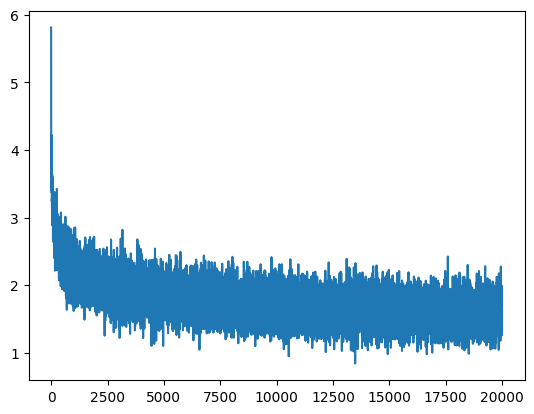

In [336]:
plt.plot(torch.tensor(losses))

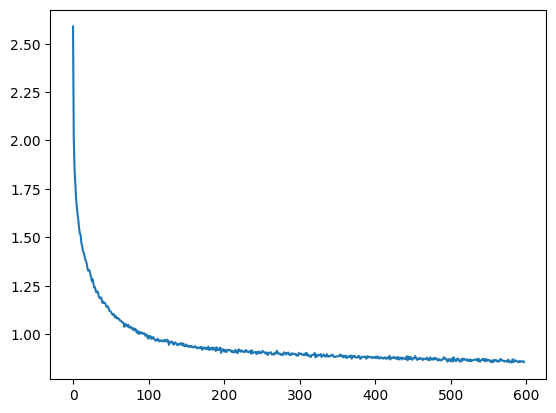

In [382]:
plt.plot(torch.tensor(losses[:-525]).view(-1, 1000).mean(1))

In [340]:
len(val_losses)

6091

In [383]:
train_loss = torch.tensor(losses[-1000:]).mean().item()
val_loss = torch.tensor(val_losses).mean().item()
print("train loss: ", train_loss)
print("val loss: ", val_loss)

train loss:  0.8648499250411987
val loss:  1.742585301399231


In [373]:
count = 0
for param in model.parameters():
    count += param.numel()

print(count)

3040407


In [375]:
CONTEXT_LENGTH

128

In [384]:
generated = "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"
# context = [tokeniser['<s>']] * CONTEXT_LENGTH
context = [tokeniser[c] for c in "[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly"]
for i in range(1000):
    pred = model.generate(torch.tensor(context).unsqueeze(0).to(device))
    token = pred.item()

    context = context[1:] + [token]
    generated += detokeniser[token]
print(generated)

[07/12/2025, 11:06:52] Yi Hein: how will we ever know when FEP assumptions hold true? if not we will just be applying it wrongly of elex for mutation forgies to trying one stemally big pretty solve sure aps. i sears the unforts disgruent in saying bas justify than relativing withs a is that’s not foruthm sritting in wed between!

[13/01/2026, 20:24:11] Haziq KXHL: the one automatism because say really what then our can squine to guys goodor. response)



this see you so completely mathing my things you at restro usclubinated anno, a second place, then interested, and view call in this over that field is

[09/01/2026, 01:30:30] Haziq KXHL: *30 being about!

[10/12/2025, 07:33:19] Haziq KXHL: i an and job this'olrakis

[10/12/2025, 20:06:43] ~ Adam: I to even needers?

[15/08/2025, 20:51:27] ~ Adam ‎: you canLt the gead of gods

[09/12/2025, 04:57:31] ~ MS: I think? humanagring

[09/01/2026, 04:02:30] ~ manav: Ahaught

 3nier and a more a quite with the the cave and set of but is great a